In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.polynomial.polynomial import polyval2d
from numpy.polynomial.chebyshev import chebval2d
from scipy.stats import multivariate_normal
import scipy.signal

from astropy.visualization import ZScaleInterval
interval = ZScaleInterval()
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn import linear_model

from scipy.stats import sigmaclip

import patsy
from patsy import dmatrix

from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import Axes3D

https://patsy.readthedocs.io/en/latest/quickstart.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.BSpline.html

https://patsy.readthedocs.io/en/latest/spline-regression.html

https://patsy.readthedocs.io/en/latest/API-reference.html#patsy.bs

In [2]:
def compute_xy_grids(x_len, y_len):
    x = np.arange(- x_len // 2 + 1, x_len // 2 + 1, 1)
    y = np.arange(- y_len // 2 + 1, y_len // 2 + 1, 1)
    xx, yy = np.meshgrid(x, y)
    return xx, yy
    
def gaussian2d(xx, yy, m=[0., 0.], cov=[[1, 0], [0, 1]]):
    grid = np.dstack((xx, yy))
    var = multivariate_normal(mean=m, cov=cov)
    return var.pdf(grid)

def sim_source_catalog(n_sources, x_lim, y_lim, min_flux, max_flux, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)
    x_pos = np.random.uniform(x_lim[0], x_lim[1], n_sources)
    y_pos = np.random.uniform(y_lim[0], y_lim[1], n_sources)  
    fluxes = np.random.uniform(min_flux, max_flux, n_sources)
    source_catalog = {'x_pos': x_pos, 'y_pos': y_pos, 'fluxes': fluxes}
    return source_catalog

def sim_image(image_size, sky_sig, psf_sig, source_catalog, random_seed=None):
    image_xx, image_yy = compute_xy_grids(image_size, image_size)
    image_grid = np.dstack((image_xx, image_yy))
    image =  np.random.normal(scale=sky_sig, size=(image_size, image_size))
    # add background sources
    fluxes = source_catalog['fluxes']
    x_pos, y_pos = source_catalog['x_pos'], source_catalog['y_pos']
    if random_seed is not None:
        print('Turning on patial variation')
        np.random.seed(random_seed)
        x_pos = x_pos + np.random.uniform(-0.1, 0.1, len(x_pos))
    for i in range(len(fluxes)):
        image += fluxes[i] * gaussian2d(
            image_xx, image_yy, m=[x_pos[i], y_pos[i]], cov=[[psf_sig, 0], [0, psf_sig]]
        )
    return image


def chebGauss2d(xx, yy, gauss_cov, poly_deg):
    # compute Gaussian
    gau = gaussian2d(xx, yy, cov=gauss_cov)
    # compute Chebyshev
    x_deg, y_deg = poly_deg[0], poly_deg[1]
    coef_x = np.zeros(x_deg + 1)
    coef_x[x_deg] = 1
    coef_y = np.zeros(y_deg + 1)
    coef_y[y_deg] = 1
    coefs = np.outer(coef_x, coef_y)
    cheb = chebval2d(xx, yy, c=coefs)
    return cheb * gau

def compute_kernel_bases(kernel_size, sig_ls, poly_deg_ls):
    xx, yy = compute_xy_grids(kernel_size, kernel_size)
    kernel_bases = []
    for id_x, x_sig in enumerate(sig_ls):
        for id_y, y_sig in enumerate(sig_ls):
            for x_deg in range(poly_deg_ls[id_x]+1):
                for y_deg in range(poly_deg_ls[id_y]+1):
                    gauss_cov = [[x_sig, 0.], [0., y_sig]]
                    poly_deg = (x_deg, y_deg)
                    kernel_bases.append(chebGauss2d(xx, yy, gauss_cov, poly_deg))   
    return kernel_bases

def compute_base_image_matrix(template, kernel_bases):
    base_im_ls = []
    for basis in kernel_bases:
        base_im = scipy.signal.fftconvolve(template, basis, mode='same')
        base_im_ls.append(base_im.flatten())
    base_image_matrix = np.vstack(base_im_ls).T   
    return base_image_matrix

def compute_spatial_image_matrix(xx, yy, spatial_deg, verbose=False):
    spatial_image_ls = []
    for x_deg in range(spatial_deg + 1):
        for y_deg in range(spatial_deg - x_deg + 1):
            if verbose:
                print(x_deg, y_deg)
            coef_x = np.zeros(x_deg + 1)
            coef_x[x_deg] = 1
            coef_y = np.zeros(y_deg + 1)
            coef_y[y_deg] = 1
            coefs = np.outer(coef_x, coef_y)
            spatial_image = polyval2d(xx, yy, c=coefs)
            spatial_image_ls.append(spatial_image.flatten())
    spatial_image_matrix = np.vstack(spatial_image_ls).T
    return spatial_image_matrix


def compute_base_spatial_image_matrix(base_image_matrix, kernel_spatial_image_matrix):
    base_spatial_vec_ls = []
    for i in range(base_image_matrix.shape[1]):
        base_vec = base_image_matrix[:, i]
        for j in range(kernel_spatial_image_matrix.shape[1]):
            kernel_spatial_vec = kernel_spatial_image_matrix[:, j]
            base_spatial_vec = base_vec * kernel_spatial_vec
            base_spatial_vec_ls.append(base_spatial_vec)
    base_spatial_image_matrix = np.vstack(base_spatial_vec_ls).T
    return base_spatial_image_matrix

def compute_X(template, kernel_size, gauss_sig_ls, poly_deg_ls,
              kernel_spatial_deg, background_spatial_deg):
    # spatial expansion
    Nx, Ny = template.shape[1], template.shape[0]
    image_xx, image_yy = compute_xy_grids(Nx, Ny)
    xx_norm, yy_norm = image_xx / Nx, image_yy / Ny
    # compute base image matrix
    kernel_bases = compute_kernel_bases(kernel_size, gauss_sig_ls, poly_deg_ls)
    base_image_matrix = compute_base_image_matrix(template, kernel_bases)
    # compuate spatial image matrix
    kernel_spatial_image_matrix = compute_spatial_image_matrix(xx_norm, yy_norm, kernel_spatial_deg, verbose=False)
    background_spatial_image_matrix = compute_spatial_image_matrix(xx_norm, yy_norm, background_spatial_deg, verbose=False)
    # compute base spatial image matrix
    base_spatial_image_matrix = compute_base_spatial_image_matrix(
        base_image_matrix, kernel_spatial_image_matrix)
    # compute X
    X = np.concatenate((base_spatial_image_matrix, background_spatial_image_matrix), axis=1)
    return X

In [3]:
x = np.linspace(0., 1., 100)
y = dmatrix("bs(x, df=6, degree=3, include_intercept=True) - 1", {"x": x})

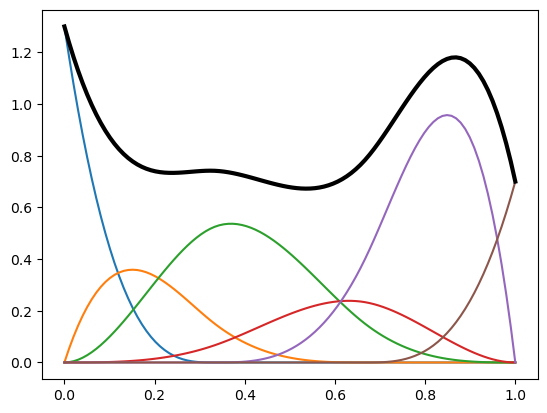

In [7]:
# Define some coefficients
b = np.array([1.3, 0.6, 0.9, 0.4, 1.6, 0.7])

# Plot B-spline basis functions (colored curves) each multiplied by its coeff
plt.plot(x, y*b);

# Plot the spline itself (sum of the basis functions, thick black curve)
plt.plot(x, np.dot(y, b), color='k', linewidth=3);

In [8]:
y.shape

(100, 6)

Text(0.5, 1.0, 'B-spline basis')

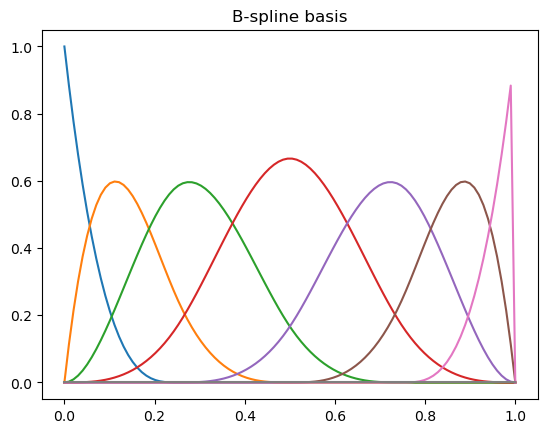

In [9]:
knots = np.linspace(0,1,5)
x = np.linspace(0., 1., 100)
y = patsy.bs(x, knots=knots, degree=3)
plt.plot(x,y)
plt.title('B-spline basis')

/pscratch/sd/s/shl159/projects/update_plots/dia_improvement/devel


(65025, 9)


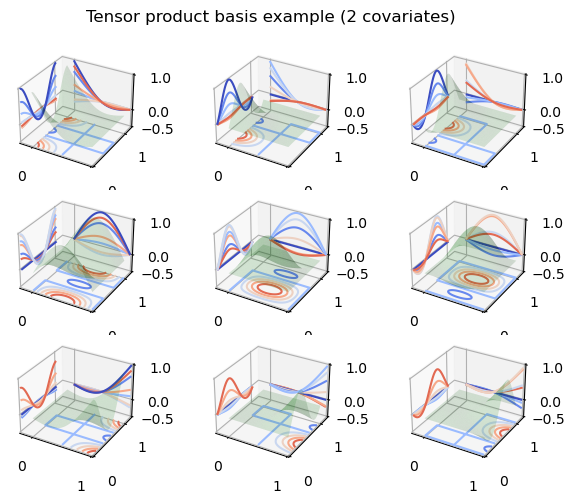

In [30]:
image_size = 255
x_len, y_len = image_size, image_size

x1 = np.arange(- x_len // 2 + 1, x_len // 2 + 1, 1)
y1 = np.arange(- y_len // 2 + 1, y_len // 2 + 1, 1)

x1 = x1 + abs(- x_len // 2 + 1)
x1 = x1 / x1[-1]

y1 = y1 + abs(- y_len // 2 + 1)
y1 = y1 / y1[-1]

x1, y1 = np.meshgrid(x1, y1)

df = 3
y = dmatrix("te(cr(x1, df), cc(y1, df)) - 1", {"x1": x1.ravel(), "y1": y1.ravel(), "df": df})

print(y.shape)

fig = plt.figure()
fig.suptitle("Tensor product basis example (2 covariates)");

for i in range(df * df):
    ax = fig.add_subplot(df, df, i + 1, projection='3d')
    yi = y[:, i].reshape(x1.shape)
    ax.plot_surface(x1, y1, yi, color='green', rstride=4, cstride=4, alpha=0.15)
    ax.contour(x1, y1, yi, zdir='z', cmap=cm.coolwarm, offset=-0.5)
    ax.contour(x1, y1, yi, zdir='y', cmap=cm.coolwarm, offset=1.2)
    ax.contour(x1, y1, yi, zdir='x', cmap=cm.coolwarm, offset=-0.2)
    ax.set_xlim3d(-0.2, 1.0)
    ax.set_ylim3d(0, 1.2)
    ax.set_zlim3d(-0.5, 1)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_zticks([-0.5, 0, 1])
fig.tight_layout()

In [10]:
image_size = 255
x_len, y_len = image_size, image_size

x1 = np.arange(- x_len // 2 + 1, x_len // 2 + 1, 1)
y1 = np.arange(- y_len // 2 + 1, y_len // 2 + 1, 1)

# x1 = x1 + abs(- x_len // 2 + 1)
# x1 = x1 / x1[-1]

# y1 = y1 + abs(- y_len // 2 + 1)
# y1 = y1 / y1[-1]

x1, y1 = np.meshgrid(x1, y1)

df = 3
y = dmatrix("te(cr(x1, df), cc(y1, df)) - 1", {"x1": x1.ravel(), "y1": y1.ravel(), "df": df})

In [11]:
bsplines = dmatrix("te(cr(x1, df), cc(y1, df)) - 1", {"x1": x1.ravel(), "y1": y1.ravel(), "df": df})

In [12]:
image_size = 255
# simulate source catalog
n_background_sources = 20
# image size
edge_offset = 10
x_lim = (- image_size//2 + 1 + edge_offset, image_size//2 + 1 - edge_offset)
y_lim = (- image_size//2 + 1 + edge_offset, image_size//2 + 1 - edge_offset)
# fluxes
min_flux, max_flux = 20000, 50000
# background source
background_src_cat = sim_source_catalog(
    n_background_sources, x_lim,  y_lim, min_flux, max_flux, random_seed=1
)
# image sigma
tmpl_sky_sig, sci_sky_sig = 0.2, 0.2
tmpl_psf_sig, sci_psf_sig = 1.6, 2.2
# simulate images
tmpl = sim_image(image_size, tmpl_sky_sig, tmpl_psf_sig, background_src_cat)
sci = sim_image(image_size, sci_sky_sig, sci_psf_sig, background_src_cat)
sci_vec = sci.flatten()
# sci_spatial = sim_image(image_size, sci_sky_sig, sci_psf_sig, background_src_cat, random_seed=0)
# sci_spatial_vec = sci_spatial.flatten()

In [13]:
# kernel parameters
gauss_sig_ls = [0.75, 1.5, 3.0]
poly_deg_ls = [4, 2, 2]
kernel_size = 31
# spatial degree of freedom
kernel_spatial_deg = 2
background_spatial_deg = 1

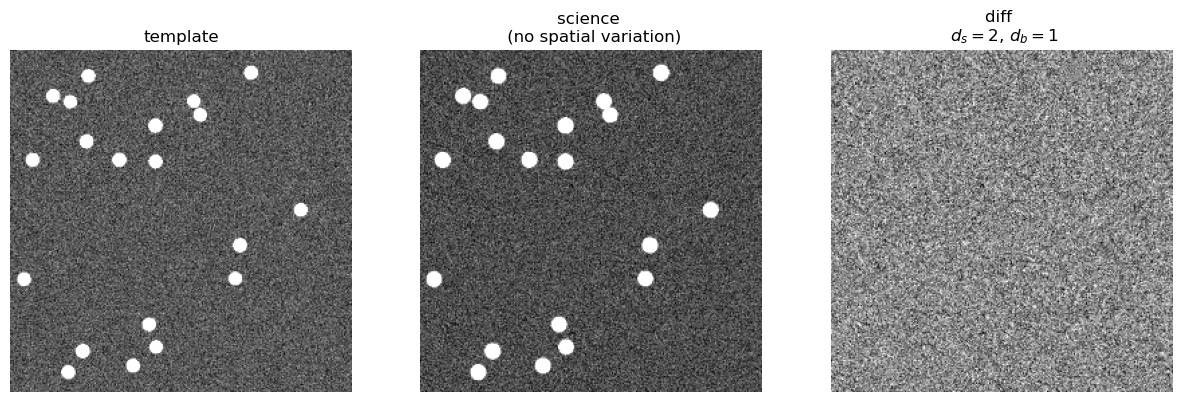

In [14]:
X = compute_X(tmpl, kernel_size, gauss_sig_ls, poly_deg_ls,
              kernel_spatial_deg, background_spatial_deg)

lin = linear_model.LinearRegression()
lin.fit(X, sci_vec)
sci_pred = lin.predict(X)
diff = sci - sci_pred.reshape(tmpl.shape)

fig, ax = plt.subplots(1, 3, figsize=(15, 15))
title_ls = ['template', 'science \n (no spatial variation)',
            'diff \n $d_s=2$, $d_b=1$']
ax[0].imshow(interval(tmpl), cmap='gray', origin='lower')
ax[1].imshow(interval(sci), cmap='gray', origin='lower')
ax[2].imshow(interval(diff), cmap='gray', origin='lower')
for i in range(3): ax[i].set_axis_off() 
for i in range(3): ax[i].set_title(title_ls[i]) 

In [15]:
template = tmpl
Nx, Ny = template.shape[1], template.shape[0]
image_xx, image_yy = compute_xy_grids(Nx, Ny)
xx_norm, yy_norm = image_xx / Nx, image_yy / Ny
# compute base image matrix
kernel_bases = compute_kernel_bases(kernel_size, gauss_sig_ls, poly_deg_ls)
base_image_matrix = compute_base_image_matrix(template, kernel_bases)
# compuate spatial image matrix
# kernel_spatial_image_matrix = compute_spatial_image_matrix(xx_norm, yy_norm, kernel_spatial_deg, verbose=False)
kernel_spatial_image_matrix = bsplines
background_spatial_image_matrix = compute_spatial_image_matrix(xx_norm, yy_norm, background_spatial_deg, verbose=False)
# compute base spatial image matrix
base_spatial_image_matrix = compute_base_spatial_image_matrix(
        base_image_matrix, kernel_spatial_image_matrix)
# compute X
X = np.concatenate((base_spatial_image_matrix, background_spatial_image_matrix), axis=1)


In [18]:
kernel_spatial_image_matrix.shape

(65025, 9)

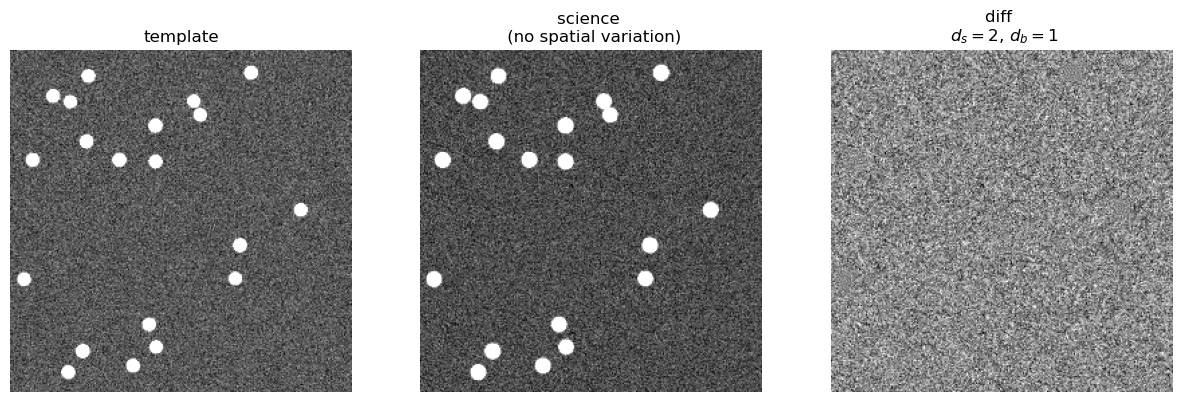

In [17]:
lin = linear_model.LinearRegression()
lin.fit(X, sci_vec)

sci_pred = lin.predict(X)
diff2 = sci - sci_pred.reshape(tmpl.shape)

fig, ax = plt.subplots(1, 3, figsize=(15, 15))
title_ls = ['template', 'science \n (no spatial variation)',
            'diff \n $d_s=2$, $d_b=1$']
ax[0].imshow(interval(tmpl), cmap='gray', origin='lower')
ax[1].imshow(interval(sci), cmap='gray', origin='lower')
ax[2].imshow(interval(diff2), cmap='gray', origin='lower')
for i in range(3): ax[i].set_axis_off() 
for i in range(3): ax[i].set_title(title_ls[i])

(array([5.0000e+00, 1.1000e+01, 8.3000e+01, 3.0600e+02, 1.3060e+03,
        6.1421e+04, 1.4330e+03, 3.7300e+02, 7.0000e+01, 1.7000e+01]),
 array([-0.29709352, -0.24329381, -0.18949411, -0.1356944 , -0.0818947 ,
        -0.028095  ,  0.02570471,  0.07950441,  0.13330412,  0.18710382,
         0.24090353]),
 <BarContainer object of 10 artists>)

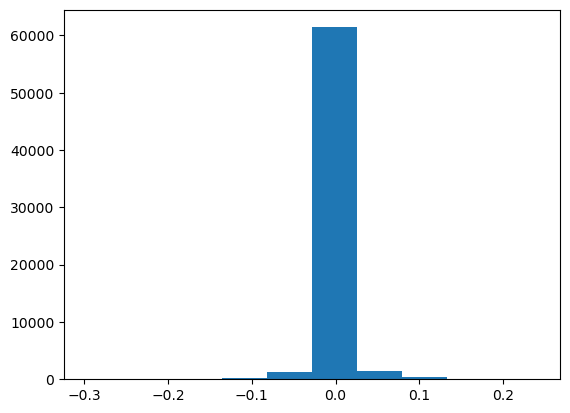

In [19]:
plt.hist((diff2 - diff).ravel())

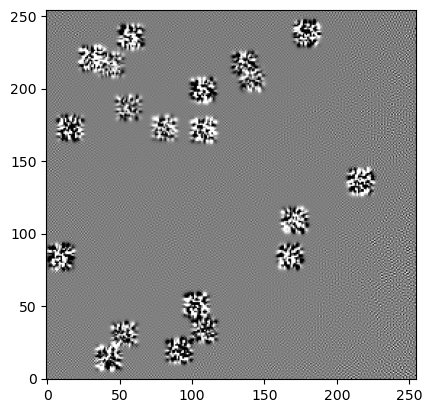

In [20]:
plt.imshow(interval(diff - diff2), cmap='gray', origin='lower')